In this notebook I am using pytorch for deep learning. It iuses the original data set which is generated with a rather random playing computer. 

In [1]:
#standard modukles
import numpy as np
import random as random
import time
import pandas as pd
#using simpleguitk for display, is not needed for computer game
#likely not needed un this notebook 
import simpleguitk as simplegui
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#for efficient saving and loading
import pickle
#skyjp game classes and functions
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for machine learning
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
#likely some uneeded ijmported
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
#time logging
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
#again tensorflow problem work before with conda install cudatoolkit, is not needed after each restart? 

Below I create the column vector.

In [2]:

columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card')            
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print("The first 30 columns are the features")
print(columns[0:30])
print("The last three are not features. The differential of the first two is the target andthe last is the ignored row index")
print(columns[30:33])

['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_cards_5', 'other_player_cards_6', 'other_player_cards_7', 'other_player_cards_8', 'other_player_cards_9', 'other_player_cards_10', 'other_player_cards_11', 'action_take_open', 'action_discard', 'discard_value', 'id_player_card', 'numeric_player_card', 'score_self', 'score_other', 'round']
The first 30 columns are the features
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_ca

Three different data sets are combined to one. All columns are used here, since the neural net should be able 
to ignore unimportant ones. 

In [3]:
df1=pd.read_pickle('level_rand_v2_0_600000_0.pkl')
df2=pd.read_pickle('level_rand_v2_0_600000_1.pkl')
df3=pd.read_pickle('level_rand_v2_0_600000_2.pkl')
df4=pd.read_pickle('level_rand_v2_0_600000_3.pkl')
df5=pd.read_pickle('level_rand_v2_0_600000_4.pkl')
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)
#free space
df1=0
df2=0
df3=0
df4=0
df5=0

(600000, 33) (3000000, 33)


Now I divide into test, train and validation and also into features and target. 

In [4]:
feature_train,feature_test,feature_valid, target_train,target_test,target_valid=split_test_valid(df.iloc[:,0:30],df.score_self-df.score_other,0.5,0.8)
print(feature_train.shape,feature_test.shape,target_test.shape,feature_train.head())

1500000
2400000
(1500000, 30) (900000, 30) (900000,)    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   other_player_cards_7  other_player_cards_8  other_play

Here is xgboost for comparison. 

In [5]:
resd=np.loadtxt('xgb_v2_maxd5.txt')
rese=np.loadtxt('xgb_v2_maxd6.txt')
resf=np.loadtxt('xgb_v2_maxd7.txt')
resg=np.loadtxt('xgb_v2_maxd8.txt')
resh=np.loadtxt('xgb_v2_maxd9.txt')
resi=np.loadtxt('xgb_v2_maxd10.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resd[3]),4)} of max-depth=5")
print(f"minimum standard deviation of (prediction-test data) {round(min(rese[3]),4)} of max-depth=6")
print(f"minimum standard deviation of (prediction-test data) {round(min(resf[3]),4)} of max-depth=7")
print(f"minimum standard deviation of (prediction-test data) {round(min(resg[3]),4)} of max-depth=8")
print(f"minimum standard deviation of (prediction-test data) {round(min(resh[3]),4)} of max-depth=9")
print(f"minimum standard deviation of (prediction-test data) {round(min(resi[3]),4)} of max-depth=10")

minimum standard deviation of (prediction-test data) 57.6014 of max-depth=5
minimum standard deviation of (prediction-test data) 57.5013 of max-depth=6
minimum standard deviation of (prediction-test data) 57.4394 of max-depth=7
minimum standard deviation of (prediction-test data) 57.4389 of max-depth=8
minimum standard deviation of (prediction-test data) 57.4242 of max-depth=9
minimum standard deviation of (prediction-test data) 57.4588 of max-depth=10


Best standard deviation is 57.4242.

Now I create the first class for regression. 

In [6]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

Here I convert the pendas data frames to numpy arrays. 

In [7]:

feature_train, target_train = np.array(feature_train), np.array(target_train)
feature_test, target_test = np.array(feature_test), np.array(target_test)
feature_valid, target_valid = np.array(feature_valid), np.array(target_valid)

Now I concat features and targets as needed by torch. 

In [8]:
#use int causes error later because wieghts are floats
train_dataset = RegressionDataset(torch.from_numpy(feature_train).float(), torch.from_numpy(target_train).float())
test_dataset = RegressionDataset(torch.from_numpy(feature_test).float(), torch.from_numpy(target_test).float())
valid_dataset = RegressionDataset(torch.from_numpy(feature_valid).float(), torch.from_numpy(target_valid).float())

This are the parameters needed, I mainly varied batch_size, but I am still not sure what is best in this cases of many rows and not so many columns. 

In [10]:
EPOCHS = 150
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NUM_FEATURES = 30

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

I am starting with a dense network of just two layers, thus just one layer more than the single layer of linear regression. 

In [11]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 10)
        self.layer_out = nn.Linear(10, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.layer_out(x)
        return (x)



In [12]:
class MultipleRegression2(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression2, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 20)
        self.layer_2 = nn.Linear(20, 10)        
        self.layer_out = nn.Linear(10, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        return (x)



In [12]:
#now 3 layers 
class MultipleRegression3(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression3, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 40)
        self.layer_2 = nn.Linear(40, 20)  
        self.layer_3 = nn.Linear(20, 8)        
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))        
        x = self.layer_out(x)
        return (x)



In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###################### OUTPUT ######################cuda:0

cpu


In [15]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=30, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
loss_stats = {
    'train': [],
    "val": []
}


In [94]:
#slow with 64 batches , likely larger better as for tensorflow
#10000 at 11:36 started 11:56 epoch 12 mse 4019 4023
#100000 at 11:57 started  maybe faster but improvement is slower 12:12 epoch 10 4107 and 4108
#1024 at 12:15 13:15 validation getsbest was 3907
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 4105.55947 | Val Loss: 4083.99538
Epoch 002: | Train Loss: 4062.55707 | Val Loss: 4046.96144
Epoch 003: | Train Loss: 4036.13904 | Val Loss: 4030.64457
Epoch 004: | Train Loss: 4022.85640 | Val Loss: 4018.98036
Epoch 005: | Train Loss: 4011.00434 | Val Loss: 4008.88819
Epoch 006: | Train Loss: 4001.88734 | Val Loss: 3999.47147
Epoch 007: | Train Loss: 3995.42135 | Val Loss: 3994.25424
Epoch 008: | Train Loss: 3989.06651 | Val Loss: 3985.72731
Epoch 009: | Train Loss: 3980.45235 | Val Loss: 3982.41948
Epoch 010: | Train Loss: 3972.78714 | Val Loss: 3968.35652
Epoch 011: | Train Loss: 3957.89985 | Val Loss: 3953.70244
Epoch 012: | Train Loss: 3947.10417 | Val Loss: 3944.42325
Epoch 013: | Train Loss: 3941.40366 | Val Loss: 3940.15116
Epoch 014: | Train Loss: 3936.98633 | Val Loss: 3936.35596
Epoch 015: | Train Loss: 3933.76444 | Val Loss: 3932.97289
Epoch 016: | Train Loss: 3930.44774 | Val Loss: 3929.28759
Epoch 017: | Train Loss: 3928.12622 | Val Loss: 3928.046

KeyboardInterrupt: 

Is slower thann tensorflow. Likely not optimal use of it. 

The measure is the squered standard deviation, that means the best xgboost had an MSE of 3297.54

As the next model I add one more layer to it to now two laters before the output layer. 

In [ ]:
#should improve at least reduce match size 
EPOCHS = 150
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NUM_FEATURES = 30
#depends on batch_size thus to be redone 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [23]:
model = MultipleRegression2(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


MultipleRegression2(
  (layer_1): Linear(in_features=30, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [24]:
loss_stats = {
    'train': [],
    "val": []
}


In [25]:
#two layers model 
#start about 15:27 is better, one layer seems never enough, 16:01 epoch 20 3672 not enough still clear improvement
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 4088.17872 | Val Loss: 4042.49844
Epoch 002: | Train Loss: 4003.61026 | Val Loss: 3975.01990
Epoch 003: | Train Loss: 3941.41271 | Val Loss: 3912.77088
Epoch 004: | Train Loss: 3893.41278 | Val Loss: 3879.09932
Epoch 005: | Train Loss: 3855.28977 | Val Loss: 3839.36777
Epoch 006: | Train Loss: 3825.19496 | Val Loss: 3811.99850
Epoch 007: | Train Loss: 3801.53642 | Val Loss: 3796.07788
Epoch 008: | Train Loss: 3780.38991 | Val Loss: 3769.23003
Epoch 009: | Train Loss: 3760.36392 | Val Loss: 3753.23314
Epoch 010: | Train Loss: 3746.01161 | Val Loss: 3749.13802
Epoch 011: | Train Loss: 3733.94495 | Val Loss: 3738.42893
Epoch 012: | Train Loss: 3720.72332 | Val Loss: 3715.80087
Epoch 013: | Train Loss: 3712.73223 | Val Loss: 3716.50719
Epoch 014: | Train Loss: 3705.49096 | Val Loss: 3704.24035
Epoch 015: | Train Loss: 3698.89745 | Val Loss: 3697.26908
Epoch 016: | Train Loss: 3694.99906 | Val Loss: 3699.80824
Epoch 017: | Train Loss: 3689.02381 | Val Loss: 3695.675

KeyboardInterrupt: 

Now 3 layers and less epochs at once. 

In [18]:
EPOCHS = 5
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NUM_FEATURES = 30
#depends on batch_size thus to be redone 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [19]:
#load last results
PATH='/home/tobias/ml-testing/games/skyjo/mlp_3layers_noreg_50epochs.pkl'
model =MultipleRegression3(NUM_FEATURES)
model.load_state_dict(torch.load(PATH))
model.eval()
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression3(
  (layer_1): Linear(in_features=30, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [20]:
loss_stats = {
    'train': [],
    "val": [],
     "test": []
}


In [61]:
#now faster converging starting again at 30 epochs, should save all outputs
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))  
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['test'].append(test_epoch_loss/len(test_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')

Begin training.


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3268.71027 | Val Loss: 3270.58070 | Test Loss: 3278.19344
Epoch 002: | Train Loss: 3267.47840 | Val Loss: 3262.27195 | Test Loss: 3272.27016
Epoch 003: | Train Loss: 3266.65204 | Val Loss: 3286.08552 | Test Loss: 3292.91425
Epoch 004: | Train Loss: 3265.95176 | Val Loss: 3257.22794 | Test Loss: 3265.44574
Epoch 005: | Train Loss: 3265.88396 | Val Loss: 3271.03374 | Test Loss: 3280.67910


In [13]:
mses=np.zeros((4,10))
mses[0,0]=10
mses[1,0]=3455.70294
mses[2,0]=3445.79746
mses[0,1]=20
mses[1,1]=3336.40219
mses[2,1]=3320.07868
mses[0,2]=30
mses[1,2]=3306.06264
mses[2,2]=3291.96560
mses[0,3]=40
mses[1,3]=3290.36522
mses[2,3]=3280.56879
mses[3,3]=3289.86262
mses[0,4]=45
mses[1,4]=3284.90320
mses[2,4]=3272.13150
mses[3,4]=3281.47121
mses[0,5]=50
mses[1,5]=3279.07807
mses[2,5]=3283.51253
mses[3,5]=3292.04370
mses[0,6]=55
mses[1,6]=3273.76096
mses[2,6]=3269.62540
mses[3,6]=3276.74123
mses[0,7]=60
mses[1,7]=3269.36649
mses[2,7]=3273.71125
mses[3,7]=3282.74199
mses[0,8]=65
mses[1,8]=3268.46204
mses[2,8]=3273.47151
mses[3,8]=3281.71029
mses[0,9]=70
mses[1,9]=3265.88396 
mses[2,9]=3271.03374
mses[3,9]=3280.67910

In [14]:
def get_std_all(data):
    for i in range(data.shape[1]):
        print(f"The standard deviation after {int(data[0,i])} epochs")
        print(f"train: {np.round(np.sqrt(data[1,i]),4)}")
        if data[3,i]==0:
             print(f"validation: {np.round(np.sqrt(data[2,i]),4)}\n")  
        else:                         
             print(f"validation: {np.round(np.sqrt(data[2,i]),4)}") 
             print(f"test: {np.round(np.sqrt(data[3,i]),4)}\n")                                    

In [15]:
get_std_all(mses)

The standard deviation after 10 epochs
train: 58.7852
validation: 58.7009

The standard deviation after 20 epochs
train: 57.7616
validation: 57.6201

The standard deviation after 30 epochs
train: 57.4984
validation: 57.3757

The standard deviation after 40 epochs
train: 57.3617
validation: 57.2762
test: 57.3573

The standard deviation after 45 epochs
train: 57.3141
validation: 57.2025
test: 57.2841

The standard deviation after 50 epochs
train: 57.2632
validation: 57.3019
test: 57.3763

The standard deviation after 55 epochs
train: 57.2168
validation: 57.1806
test: 57.2428

The standard deviation after 60 epochs
train: 57.1784
validation: 57.2164
test: 57.2952

The standard deviation after 65 epochs
train: 57.1705
validation: 57.2143
test: 57.2862

The standard deviation after 70 epochs
train: 57.1479
validation: 57.193
test: 57.2772



Text(0, 0.5, 'standard deviation of data-prediction [points]')

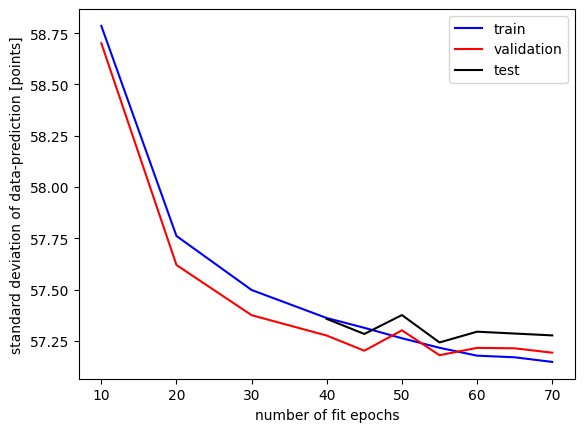

In [65]:
plt.plot(mses[0],np.sqrt(mses[1]),'-',ms=5,color='blue',label='train') 
plt.plot(mses[0],np.sqrt(mses[2]),'-',ms=5,color='red',label='validation')
plt.plot(mses[0,3:],np.sqrt(mses[3,3:]),'-',ms=5,color='black',label='test')
plt.legend(loc="best")
#plt.xscale("lin")
#plt.ylim(55,65)
plt.xlabel("number of fit epochs")
plt.ylabel("standard deviation of data-prediction [points]")

For comparison the standard deviation of the best xgboost prediction is 57.4242. After 20 epochs it gets close to it. After 30 it is better, slightly for vailidation but it also depends on the sample, and I used test before for it. Still it is of the same order now at lest. 
After 30 epochs oscillations does not anymore always improve, but still usually.

The model looks now good enough that I save it.

After 45 it looks less good it could be just chance, after most step it improves. 

The best values of the saved model is at 55, there were partlz betetr in beteween but they are saved, anwyay the difefrences are small and thus this network is not further improved. 

In [66]:
PATH='/home/tobias/ml-testing/games/skyjo/mlp_3layers_noreg_70epochs.pkl'
torch.save(model.state_dict(), PATH)

In [34]:
#loading needs class
PATH='/home/tobias/ml-testing/games/skyjo/mlp_3layers_noreg_50epochs.pkl'
model2 =MultipleRegression3(NUM_FEATURES)
model2.load_state_dict(torch.load(PATH))
model2.eval()

MultipleRegression3(
  (layer_1): Linear(in_features=30, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

Saving seems to have worked. 

In [67]:
#12:06 start 12 08 end 
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [68]:
print("in test")
mse = mean_squared_error(target_test, y_pred_list)
r_square = r2_score(target_test, y_pred_list)
std=np.std(target_test-y_pred_list)
print("after 30 epochs")
print("Mean Squared Error : 3302.0495686974614")
print("R^2 : 0.20235450378570075")
print("standard deviation : 57.45648483870122")
print("")
print("after 40 epochs")
print("Mean Squared Error 3289.862617215804:")
print("R^2 : 0.20529839265220284")
print("standard deviation : 57.34983013359584")
print("")
print("after 45 epochs")
print("Mean Squared Error : 3281.4712103010697")
print("R^2 : 0.2073254270116779",)
print("standard deviation : 57.28274882342242")
print("")
print("after 50 epochs")
print("Mean Squared Error : 3292.0437011200456")
print("R^2 : 0.20477152843745094")
print("standard deviation : 57.29357841200289")
print("")
print("after 55 epochs")
print("Mean Squared Error : 3276.7412316343666")
print("R^2 : 0.20846800409969335")
print("standard deviation 57.23602876024961:")
print("")
print("after 60 epochs")
print("Mean Squared Error : 3282.741985022386")
print("R^2 : 0.20701845774544703")
print("standard deviation : 57.20168925565616")
print("")
print("after 65 epochs")
print("Mean Squared Error : 3281.710286884228")
print("R^2 : 0.2072676754983105 ")
print("standard deviation : 57.170661063051945")
print("")
print("after 70 epochs")
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print("standard deviation :",std)

in test
after 30 epochs
Mean Squared Error : 3302.0495686974614
R^2 : 0.20235450378570075
standard deviation : 57.45648483870122

after 40 epochs
Mean Squared Error 3289.862617215804:
R^2 : 0.20529839265220284
standard deviation : 57.34983013359584

after 45 epochs
Mean Squared Error : 3281.4712103010697
R^2 : 0.2073254270116779
standard deviation : 57.28274882342242

after 50 epochs
Mean Squared Error : 3292.0437011200456
R^2 : 0.20477152843745094
standard deviation : 57.29357841200289

after 55 epochs
Mean Squared Error : 3276.7412316343666
R^2 : 0.20846800409969335
standard deviation 57.23602876024961:

after 60 epochs
Mean Squared Error : 3282.741985022386
R^2 : 0.20701845774544703
standard deviation : 57.20168925565616

after 65 epochs
Mean Squared Error : 3281.710286884228
R^2 : 0.2072676754983105 
standard deviation : 57.170661063051945

after 70 epochs
Mean Squared Error : 3280.6791029575525
R^2 : 0.20751676903787408
standard deviation : 57.17280645791893


After 30 epochs the test standard deviation is 57.4565 slightly worse than the best xgboost case of 57.4242. 
After 40 epochs it is slightly better. After 45 epochs there is not always improvement, over fitting seems to be matter now, even when it does not get really bad. 55 is best of the explored range.  


Now adding one layer more. 

In [17]:
#now 4 layers 
class MultipleRegression4(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression4, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 40)
        self.layer_2 = nn.Linear(40, 40)          
        self.layer_3 = nn.Linear(40, 20)  
        self.layer_4 = nn.Linear(20, 8)        
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))   
        x = self.relu(self.layer_4(x))         
        x = self.layer_out(x)
        return (x)



In [18]:
EPOCHS = 5
BATCH_SIZE = 1024
LEARNING_RATE = 0.001
NUM_FEATURES = 30
#depends on batch_size thus to be redone 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valid_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [19]:
model =MultipleRegression4(NUM_FEATURES)
#model.load_state_dict(torch.load(PATH))
model.eval()
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression4(
  (layer_1): Linear(in_features=30, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=40, bias=True)
  (layer_3): Linear(in_features=40, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
#load last results
PATH='/home/tobias/ml-testing/games/skyjo/mlp_4layers_noreg_10epochs.pkl'
model =MultipleRegression4(NUM_FEATURES)
model.load_state_dict(torch.load(PATH))
model.eval()
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression4(
  (layer_1): Linear(in_features=30, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=40, bias=True)
  (layer_3): Linear(in_features=40, out_features=20, bias=True)
  (layer_4): Linear(in_features=20, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [31]:
loss_stats = {
    'train': [],
    "val": [],
     "test": []
}


In [ ]:
#faster converging 
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))  
    with torch.no_grad():
        
        test_epoch_loss = 0
        
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch.unsqueeze(1))
            
            test_epoch_loss += test_loss.item()
    loss_stats['test'].append(test_epoch_loss/len(test_loader))
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Test Loss: {test_epoch_loss/len(test_loader):.5f}')
    
PATH='/home/tobias/ml-testing/games/skyjo/mlp_4layers_noreg_20epochs.pkl'
torch.save(model.state_dict(), PATH)

Begin training.


  0%|          | 0/5 [00:00<?, ?it/s]

Seems to get faster an issue of overfitting, or still just chance? 

In [34]:
#3 layers at 10   3455.70294   3445.79746
mses2=np.zeros((4,10))
mses2[0,0]=5
mses2[1,0]=3535.98586
mses2[2,0]=3518.31515
mses2[3,0]=3526.59187
mses2[0,1]=10
mses2[1,1]=3446.88787
mses2[2,1]=3432.32044
mses2[3,1]=3441.40811
mses2[0,2]=15
mses2[1,2]=3387.61147
mses2[2,2]=3401.31731
mses2[3,2]=3409.94138
mses2[0,3]=20
#mses2[1,2]=
#mses2[2,2]=
#mses2[3,2]=

In [36]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [38]:
print("in test")
mse = mean_squared_error(target_test, y_pred_list)
r_square = r2_score(target_test, y_pred_list)
std=np.std(target_test-y_pred_list)
print("after 5 epochs")
print("Mean Squared Error : 3526.5918661257133")
print("R^2 : 0.1481139030536206")
print("standard deviation : 59.31655808656255")
print("after 15 epochs")
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print("standard deviation :",std)

in test
after 5 epochs
Mean Squared Error : 3526.5918661257133
R^2 : 0.1481139030536206
standard deviation : 59.31655808656255
after 15 epochs
Mean Squared Error : 3409.941383982295
R^2 : 0.17629207838901617
standard deviation : 58.16301216884357


Text(0, 0.5, 'standard deviation of data-prediction [points]')

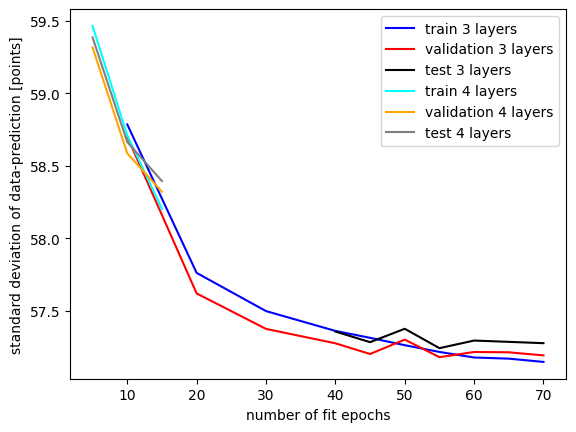

In [35]:
plt.plot(mses[0],np.sqrt(mses[1]),'-',ms=5,color='blue',label='train 3 layers') 
plt.plot(mses[0],np.sqrt(mses[2]),'-',ms=5,color='red',label='validation 3 layers')
plt.plot(mses[0,3:],np.sqrt(mses[3,3:]),'-',ms=5,color='black',label='test 3 layers')
plt.plot(mses2[0,0:3],np.sqrt(mses2[1,0:3]),'-',ms=5,color='cyan',label='train 4 layers') 
plt.plot(mses2[0,0:3],np.sqrt(mses2[2,0:3]),'-',ms=5,color='orange',label='validation 4 layers') 
plt.plot(mses2[0,0:3],np.sqrt(mses2[3,0:3]),'-',ms=5,color='gray',label='test 4 layers') 
plt.legend(loc="best")
#plt.xscale("lin")
#plt.ylim(55,65)
plt.xlabel("number of fit epochs")
plt.ylabel("standard deviation of data-prediction [points]")

A little faster convergence with 4 layers at the beginning, but more often computer problems. And less clear whether at 15 epcohs, possible overfitting starts then already. 

Now testing how to predict for a small sample. Just 15 cases like it would be during the game. 